In [29]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

Загрузим и изучим данные.

In [30]:
df = pd.read_csv('data/data.csv')
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [31]:
print('Размер набора данных:', df.shape)

Размер набора данных: (377185, 18)


Проверим наличие повторяющихся строк и удалим их при необходимости.

In [32]:
print(df.duplicated().value_counts())
df = df.drop_duplicates()

False    377135
True         50
dtype: int64


Проверим, есть ли пропуски в данных. Укажем процент таких пропусков для каждого столбца.

In [33]:
df.isna().sum()/df.shape[0]*100

status          10.584274
private pool    98.891378
propertyType     9.209699
street           0.000530
baths           28.188315
homeFacts        0.000000
fireplace       72.659127
city             0.009015
schools          0.000000
sqft            10.752118
zipcode          0.000000
beds            24.196640
state            0.000000
stories         39.952007
mls-id          93.386453
PrivatePool     89.311520
MlsId           17.730786
target           0.657589
dtype: float64

Обратим внимание, что есть столбцы со схожими названиями: private pool и PrivatePool, mls-id и MlsId. Объединим схожие столбцы.

In [34]:
df['private_pool'] = df[['private pool', 'PrivatePool']].apply(
    lambda x: 0 if (x[0] is np.NaN) and (x[1] is np.NaN) else 1, axis=1
)
df = df.drop(['private pool', 'PrivatePool'], axis=1)

mask = df['MlsId'].isna()
df.loc[~mask, 'MlsId'] = df[~mask]['MlsId'].apply(
    lambda x: np.NaN if x.strip().lower() in ('no mls', 'no mls #', 'no', 'nomlsid') else x
)

mask = df['mls-id'].isna()
df.loc[~mask, 'mls-id'] = df[~mask]['mls-id'].apply(
    lambda x: np.NaN if x.strip().lower() in ('no mls#', 'no') else x
)
df['mlsid'] = df[['mls-id', 'MlsId']].apply(
    lambda x: 0 if (x[0] is np.NaN) and (x[1] is np.NaN) else 1, axis=1
)
df = df.drop(['mls-id', 'MlsId'], axis=1)

Теперь извлечем информацию из столбца homeFacts.

In [35]:
def get_homefacts(string):
    facts_list = ast.literal_eval(string)['atAGlanceFacts']
    return (
        facts_list[0]['factValue'],
        facts_list[1]['factValue'],
        facts_list[2]['factValue'],
        facts_list[3]['factValue'],
        facts_list[4]['factValue'],
        facts_list[5]['factValue'],
        facts_list[6]['factValue']
    )

(
    df['year_built'],
    df['year_remodeled'],
    df['heating'],
    df['cooling'],
    df['parking'],
    df['lot_size'],
    df['price_sqft']
) = zip(*df['homeFacts'].apply(get_homefacts))

df = df.drop(['homeFacts'], axis=1)

Извлечем информацию из столбца schools.

In [36]:
def get_schools_info(string):
    school_dict = ast.literal_eval(string)
    rates = list()
    for rate in school_dict[0]['rating']:
         if rate == 'NR':
           rates.append(0)
         else:
           if rate.split('/')[0] in ('None', 'NR', 'NA', ''):
              rates.append(0)
           else:
              rates.append(int(rate.split('/')[0]))
    distances = list()
    for distance in school_dict[0]['data']['Distance']:
        distances.append(float(distance[:-2]))
    grades = list()
    for grade in school_dict[0]['data']['Grades']:
        grades.append(grade)
    return np.mean(rates), np.mean(distances), grades

df['school_rate_mean'], df['school_distance_mean'], df['grades'] = zip(*df['schools'].apply(get_schools_info))

df = df.drop(['schools'], axis=1)

C:\Users\maxim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Обработаем столбцы с числовыми показателями, которые содержат лишнюю текстовую информацию.

In [37]:
df['baths'] = df['baths'].str.extract('(\d+)')
df['beds'] = df['beds'].str.extract('(\d+)')
df['sqft'] = df['sqft'].str.extract('(\d+)')
df['price_sqft'] = df['price_sqft'].str.extract('(\d+)')
df['price_sqft'] = df['price_sqft'].astype(float)
df['target'] = df['target'].str.replace(',','').str.extract('(\d+)')

Удалим столбцы, из которых сложно извлечь полезную информацию.

In [38]:
df = df.drop(['grades', 'street', 'city', 'stories'], axis=1)
df = df.drop([], axis=1)

Разберемся с пропусками в столбце heating и на основе него создадим несколько бинарных признаков.

In [39]:
df['heating'] = df['heating'].str.lower()
df['heating'] = df['heating'].fillna('no heat')
print(df['heating'].str.split(', ').explode().value_counts()[:20])

df['heat_system'] = df['heating'].apply(lambda x: 0 if x.strip() in ('', 'no data', 'no', 'none', 'no heating', 'no heat') else 1)
df['forced air'] = df['heating'].apply(lambda x: 1 if 'forced air' in x else 0)
df['heat_electric'] = df['heating'].apply(lambda x: 1 if 'electric' in x else 0)
df['heat_central'] = df['heating'].apply(lambda x: 1 if 'central' in x else 0)
df['heat_gas'] = df['heating'].apply(lambda x: 1 if 'gas' in x else 0)

df = df.drop(['heating'], axis=1)

forced air             139492
                       107969
other                   30147
electric                16412
central                 12644
heat pump               12379
gas                     11528
central air              9867
central electric         8768
no data                  8610
baseboard                4490
wall                     3541
no heat                  3534
electric heat            3204
heating system           2709
ceiling fan(s)           1970
radiant                  1866
natural gas              1626
gas hot air/furnace      1486
natural gas heat         1471
Name: heating, dtype: int64


Аналогично разберемся со столбцом cooling.

In [40]:
df['cooling'] = df['cooling'].str.lower()
df['cooling'] = df['cooling'].fillna('no cool')
print(df['cooling'].str.split(', ').explode().value_counts()[:20])

df['cooling_system'] = df['cooling'].apply(lambda x: 0 if x.strip() in ('', 'no data', 'none', 'no cool', 'no') else 1)
df['cooling_central'] = df['cooling'].apply(lambda x: 1 if 'central' in x else 0)

df = df.drop(['cooling'], axis=1)

central                    162214
                           120470
central air                 18296
no data                     10615
has cooling                  9730
central electric             7976
none                         7441
wall                         4845
central gas                  4600
central a/c (electric)       3907
no cool                      3533
central heating              3332
electric                     2838
refrigeration                2767
cooling system               2700
central a/c                  2681
zoned                        2352
other                        2337
central heat (gas)           2233
central heat (electric)      1694
Name: cooling, dtype: int64


Извлечем полезную информацию из столбца parking.

In [41]:
df['parking'] = df['parking'].str.lower()
df['parking'] = df['parking'].fillna('no parking')
print(df['parking'].str.split(', ').explode().value_counts()[:20])

df['has_parking'] = df['parking'].apply(lambda x: 0 if x.strip() in ('', 'no data', 'none', 'no parking', 'no') else 1)
df['garage'] = df['parking'].apply(lambda x: 1 if 'garage' in x else 0)
df['parking_spaces'] = df['parking'].str.extract('(\d+)')

df = df.drop(['parking'], axis=1)

                        171856
attached garage          80461
2 spaces                 28061
detached garage          17018
1 space                  14253
no data                  13333
carport                  13175
off street                8181
3 spaces                  4724
no parking                3542
on street                 3370
1                         2936
4 spaces                  2917
2                         2756
driveway                  2654
none                      2405
garage door opener        1720
garage - 2 car            1559
electric door opener      1133
0                         1114
Name: parking, dtype: int64


Аналогично обработаем столбец status.

In [42]:
df['status'] = df['status'].str.lower()
df['status'] = df['status'].fillna('no status')
print(df['status'].value_counts()[:20])

df['for_sale'] = df['status'].apply(lambda x: 1 if 'for sale' in x else 0)
df['active'] = df['status'].apply(lambda x: 1 if 'active' in x else 0)
df['foreclosure'] = df['status'].apply(lambda x: 1 if 'foreclosure' in x or 'foreclosed' in x or 'auction' in x else 0)
df['new_construction'] = df['status'].apply(lambda x: 1 if 'new construction' in x else 0)

df = df.drop(['status'], axis=1)

for sale                     199524
active                       105207
no status                     39917
foreclosure                    6768
new construction               5474
pending                        4807
pre-foreclosure                2119
pre-foreclosure / auction      1560
p                              1488
under contract show            1183
 / auction                      936
under contract   showing        793
active under contract           718
under contract                  692
new                             690
contingent                      581
price change                    563
auction                         536
foreclosed                      459
a active                        443
Name: status, dtype: int64


Обработаем столбец propertyType.

In [43]:
df['propertyType'] = df['propertyType'].str.lower()
df['propertyType'] = df['propertyType'].fillna('no data')
print(df['propertyType'].value_counts()[:20])

df['single_family'] = df['propertyType'].apply(lambda x: 1 if 'single-family' in x or 'single family' in x else 0)
df['multi_family'] = df['propertyType'].apply(lambda x: 1 if 'multi-family' in x or 'multi family' in x else 0)
df['condo'] = df['propertyType'].apply(lambda x: 1 if 'condo' in x else 0)
df['land'] = df['propertyType'].apply(lambda x: 1 if 'lot' in x or 'land' in x else 0)

df = df.drop(['propertyType'], axis=1)

single-family home               92199
single family                    62867
condo                            42525
no data                          34733
single family home               31728
lot/land                         20526
townhouse                        18392
land                             10934
multi-family                      7921
condo/townhome/row home/co-op     7701
traditional                       5913
coop                              3265
multi family                      2793
high rise                         1823
ranch                             1781
mobile/manufactured               1618
detached, one story               1614
single detached, traditional      1581
contemporary                      1557
multi-family home                 1501
Name: propertyType, dtype: int64


Заполним пустые значения некоторых столбцов, исходя из общих сообращений.

In [44]:
df['baths'] = df['baths'].fillna(1)
df['fireplace'] = df['fireplace'].fillna(0)
df['beds'] = df['beds'].fillna(1)
df['parking_spaces'] = df['parking_spaces'].fillna(0)

Сделаем из столбца fireplace бинарный признак.

In [45]:
df['fireplace'] = df['fireplace'].apply(lambda x: 1 if x != 0 else 0)

Заполним пробелы полей year_built и year_remodeled.

In [46]:
mask = df['year_built'].isna()
df.loc[~mask, 'year_built'] = df[~mask]['year_built'].apply(lambda x: np.NaN if x.strip().lower() == 'no data' else x)
df['year_built'] = df['year_built'].apply(lambda x: np.NaN if x == '' else x)

mask = df['year_remodeled'].isna()
df.loc[~mask, 'year_remodeled'] = df[~mask]['year_remodeled'].apply(lambda x: np.NaN if x.strip().lower() == 'no data' else x)
df['year_remodeled'] = df['year_remodeled'].apply(lambda x: np.NaN if x == '' else x)

mask = df['year_built'].isna()
df.loc[mask, 'year_built'] = df[mask]['year_remodeled']

mask = df['year_remodeled'].isna()
df.loc[mask, 'year_remodeled'] = df[mask]['year_built']

df['year_built'] = df['year_built'].astype('float')
year_zipcode = df[~mask].groupby(by=['zipcode']).agg({'year_built' : ['count', 'mean']})
year_state = df[~mask].groupby(by=['state']).agg({'year_built' : ['count', 'mean']})

mask1 = df['year_built'].isna()
for zipcode in year_zipcode.index:
    mask2 = df['zipcode'] == zipcode
    if year_zipcode.loc[zipcode, ('year_built', 'count')] > 4:
        df.loc[mask1&mask2, 'year_built'] = year_zipcode.loc[zipcode, ('year_built', 'mean')]

for state in year_state.index:
    mask2 = df['state'] == state
    df.loc[mask1&mask2, 'year_built'] = year_state.loc[state, ('year_built', 'mean')]

mask = df['year_remodeled'].isna()
df.loc[mask, 'year_remodeled'] = df[mask]['year_built']

Заполним пробелы поля sqft.

In [47]:
df['sqft'] = df['sqft'].apply(lambda x: np.NaN if x == '' else x)
df['sqft'] = df['sqft'].astype(float)
mask = df['sqft'].isna()
year_zipcode = df[~mask].groupby(by=['zipcode']).agg({'sqft' : ['count', 'mean']})
year_state = df[~mask].groupby(by=['state']).agg({'sqft' : ['count', 'mean']})

mask1 = df['sqft'].isna()
for zipcode in year_zipcode.index:
    mask2 = df['zipcode'] == zipcode
    if year_zipcode.loc[zipcode, ('sqft', 'count')] > 4:
        df.loc[mask1&mask2, 'sqft'] = year_zipcode.loc[zipcode, ('sqft', 'mean')]

for state in year_state.index:
    mask2 = df['state'] == state
    df.loc[mask1&mask2, 'sqft'] = year_state.loc[state, ('sqft', 'mean')]

Заполним пробелы поля lot_size.

In [48]:
df['lot_size'] = df['lot_size'].apply(lambda x: np.NaN if x == '' else x)
df['lot_size'] = df['lot_size'].str.replace(',','').str.extract('(\d+)')
df['lot_size'] = df['lot_size'].astype(float)

mask = df['lot_size'].isna()
year_zipcode = df[~mask].groupby(by=['zipcode']).agg({'lot_size' : ['count', 'mean']})
year_state = df[~mask].groupby(by=['state']).agg({'lot_size' : ['count', 'mean']})

mask1 = df['lot_size'].isna()
for zipcode in year_zipcode.index:
    mask2 = df['zipcode'] == zipcode
    if year_zipcode.loc[zipcode, ('lot_size', 'count')] > 4:
        df.loc[mask1&mask2, 'lot_size'] = year_zipcode.loc[zipcode, ('lot_size', 'mean')]

for state in year_state.index:
    mask2 = df['state'] == state
    df.loc[mask1&mask2, 'lot_size'] = year_state.loc[state, ('lot_size', 'mean')]

Заполним пробелы поля school_rate_mean.

In [49]:
mask = df['school_rate_mean'].isna()
year_zipcode = df[~mask].groupby(by=['zipcode']).agg({'school_rate_mean' : ['count', 'mean']})
year_state = df[~mask].groupby(by=['state']).agg({'school_rate_mean' : ['count', 'mean']})

mask1 = df['school_rate_mean'].isna()
for zipcode in year_zipcode.index:
    mask2 = df['zipcode'] == zipcode
    if year_zipcode.loc[zipcode, ('school_rate_mean', 'count')] > 4:
        df.loc[mask1&mask2, 'school_rate_mean'] = year_zipcode.loc[zipcode, ('school_rate_mean', 'mean')]

for state in year_state.index:
    mask2 = df['state'] == state
    df.loc[mask1&mask2, 'school_rate_mean'] = year_state.loc[state, ('school_rate_mean', 'mean')]

Заполним пробелы поля school_distance_mean.

In [50]:
mask = df['school_distance_mean'].isna()
year_zipcode = df[~mask].groupby(by=['zipcode']).agg({'school_distance_mean' : ['count', 'mean']})
year_state = df[~mask].groupby(by=['state']).agg({'school_distance_mean' : ['count', 'mean']})

mask1 = df['school_distance_mean'].isna()
for zipcode in year_zipcode.index:
    mask2 = df['zipcode'] == zipcode
    if year_zipcode.loc[zipcode, ('school_distance_mean', 'count')] > 4:
        df.loc[mask1&mask2, 'school_distance_mean'] = year_zipcode.loc[zipcode, ('school_distance_mean', 'mean')]

for state in year_state.index:
    mask2 = df['state'] == state
    df.loc[mask1&mask2, 'school_distance_mean'] = year_state.loc[state, ('school_distance_mean', 'mean')]

Попробуем заполнить пробелы в столбце target.

In [51]:
mask = df['target'].isna()
df.loc[mask, 'target'] = df[mask][['price_sqft', 'sqft']].apply(
    lambda x: x[0]*x[1] if x[0] is not np.NaN and x[0] is not np.NaN else np.NaN, axis=1
)
df = df.drop(['zipcode', 'price_sqft'], axis=1)

Удалим строки с пустыми значениями, которые не удалось заполнить.

In [52]:
df = df.dropna()

Приведем признаки к нужным типам.

In [53]:
df['baths'] = df['baths'].astype(int)
df['beds'] = df['beds'].astype(int)
df['target'] = df['target'].astype(float)
df['year_built'] = df['year_built'].astype(int)
df['year_remodeled'] = df['year_remodeled'].astype(float).astype(int)
df['parking_spaces'] = df['parking_spaces'].astype(int)

Закодируем признак state.

In [80]:
df = pd.concat([df, pd.get_dummies(df['state'])], axis=1)
df = df.drop(['state'], axis=1)

Найдем и удалим выбросы.

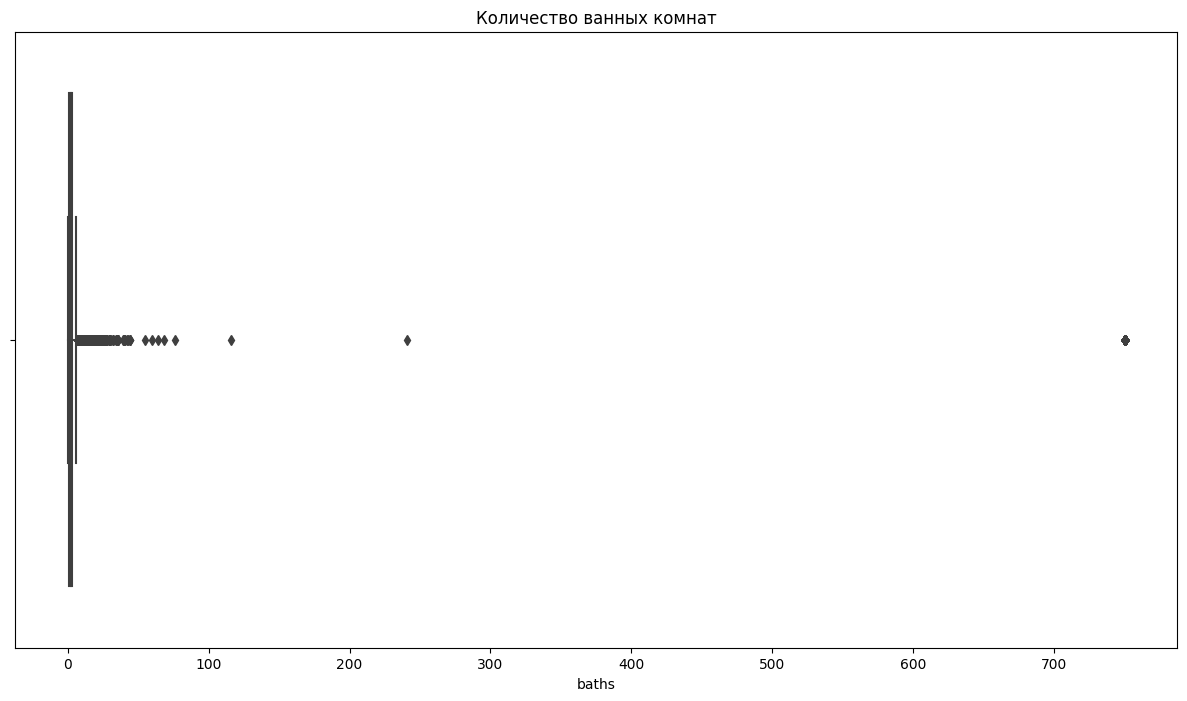

In [55]:
plt.figure(figsize=(15,8))
plt.title('Количество ванных комнат')
sns.boxplot(x=df['baths'])
plt.show()

In [56]:
mask = df['baths'] < 100
df = df[mask]

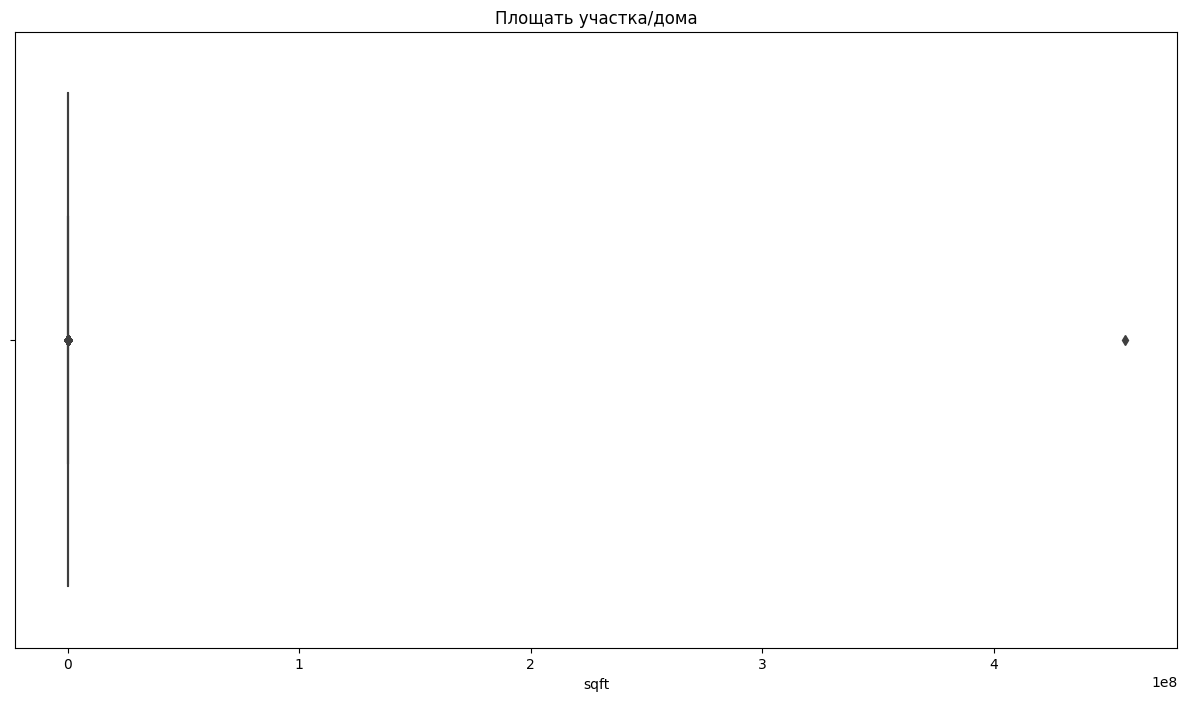

In [57]:
plt.figure(figsize=(15,8))
plt.title('Площать дома')
sns.boxplot(x=df['sqft'])
plt.show()

In [58]:
temp = df['sqft'].max()
mask = df['sqft'] == temp
df = df[~mask]

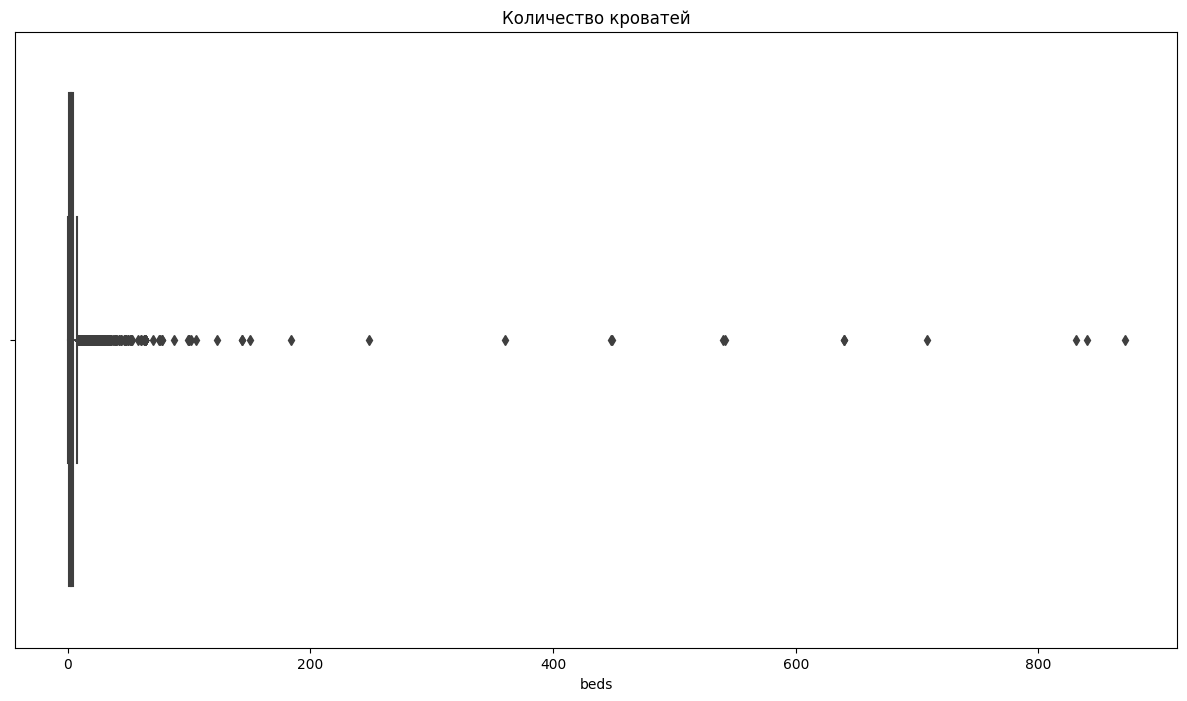

In [59]:
plt.figure(figsize=(15,8))
plt.title('Количество кроватей')
sns.boxplot(x=df['beds'])
plt.show()

In [60]:
mask = df['beds'] <= 200
df = df[mask]

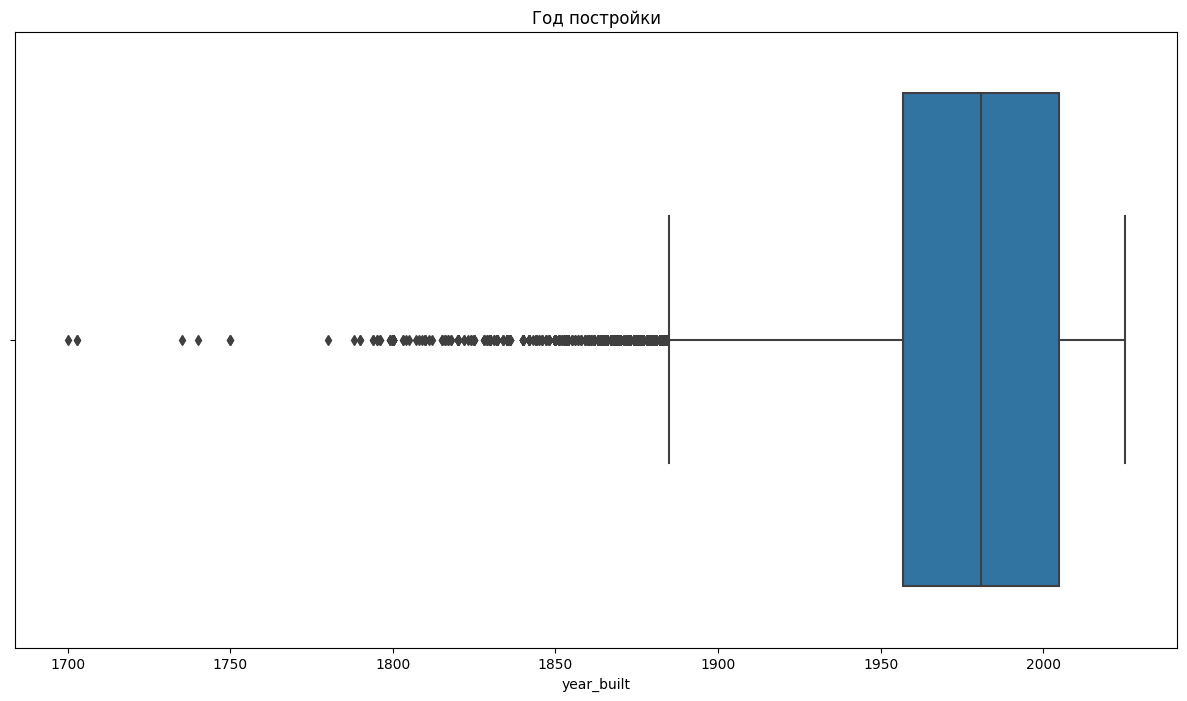

In [63]:
plt.figure(figsize=(15,8))
plt.title('Год постройки')
sns.boxplot(x=df['year_built'])
plt.show()

In [62]:
mask = df['year_built'] >= 1500
df = df[mask]

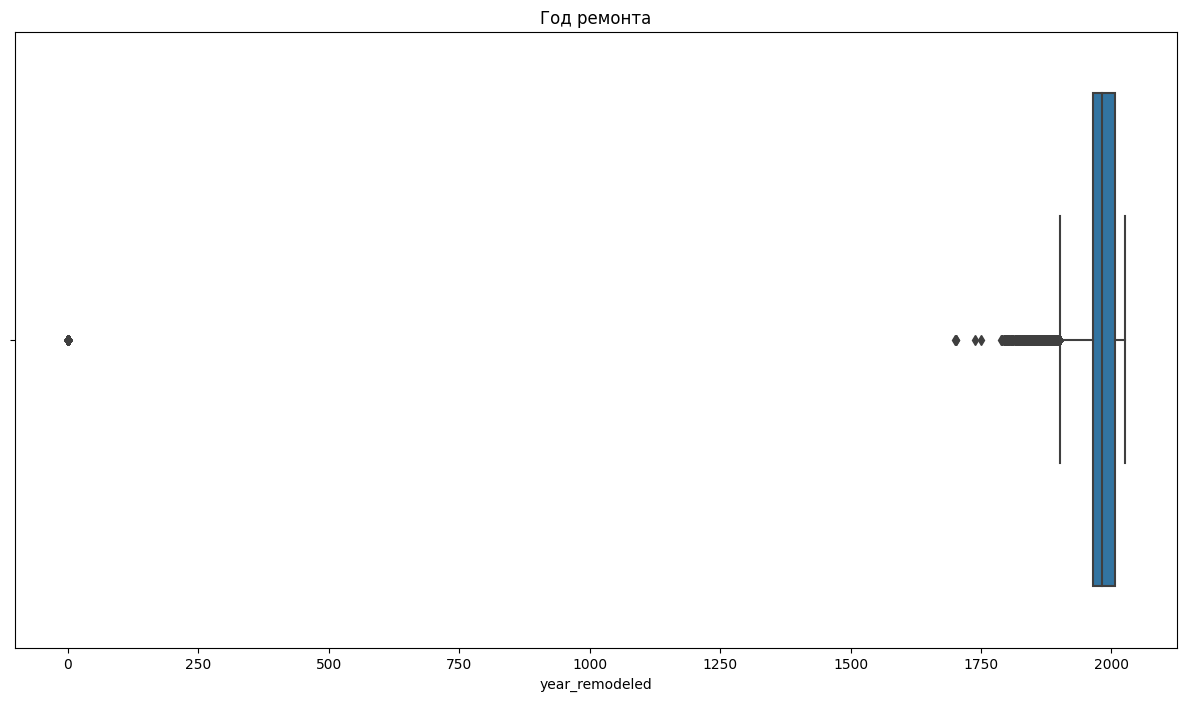

In [64]:
plt.figure(figsize=(15,8))
plt.title('Год ремонта')
sns.boxplot(x=df['year_remodeled'])
plt.show()

In [65]:
mask = df['year_remodeled'] >= 1500
df = df[mask]

Проверим, есть ли записи, где год ремонта раньше года постройки, и исправим это.

In [66]:
mask = df['year_remodeled'] < df['year_built']
temp = df[mask]['year_remodeled']
df.loc[mask, 'year_remodeled'] = df[mask]['year_built']
df.loc[mask, 'year_built'] = temp

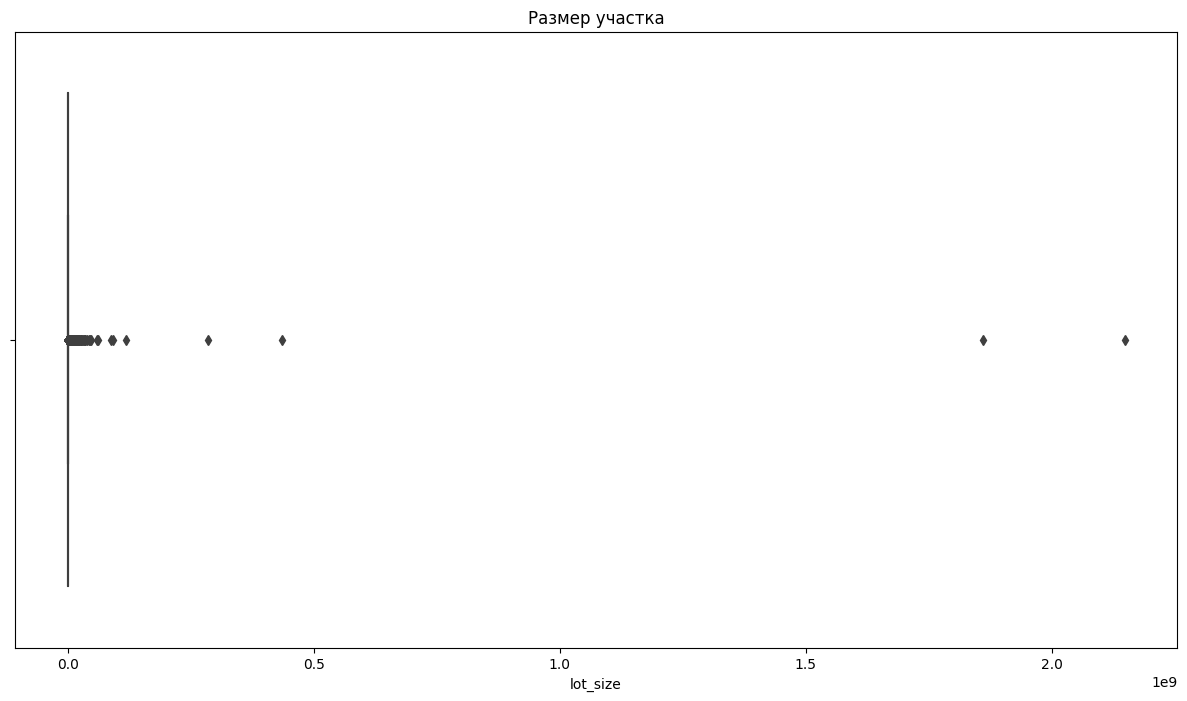

In [67]:
plt.figure(figsize=(15,8))
plt.title('Размер участка')
sns.boxplot(x=df['lot_size'])
plt.show()

In [68]:
mask = df['lot_size'] <= 250000000
df = df[mask]

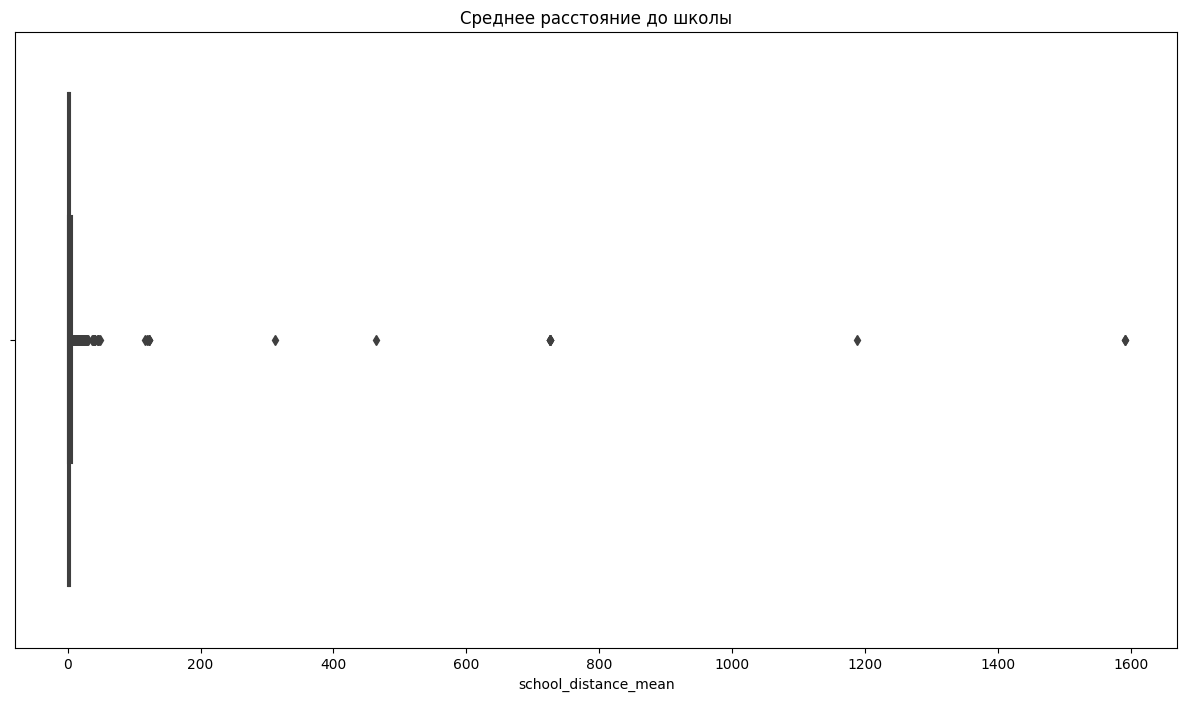

In [69]:
plt.figure(figsize=(15,8))
plt.title('Среднее расстояние до школы')
sns.boxplot(x=df['school_distance_mean'])
plt.show()

In [70]:
mask = df['school_distance_mean'] < 100
df = df[mask]

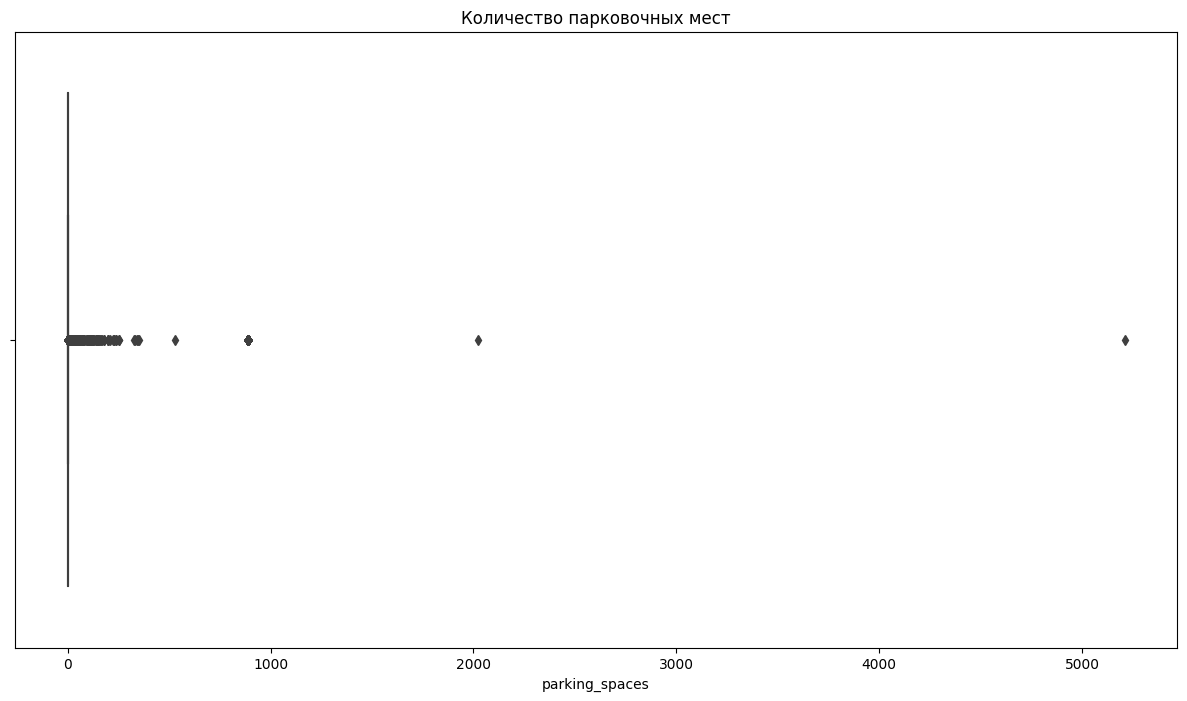

In [71]:
plt.figure(figsize=(15,8))
plt.title('Количество парковочных мест')
sns.boxplot(x=df['parking_spaces'])
plt.show()

In [72]:
mask = df['parking_spaces'] < 300
df = df[mask]

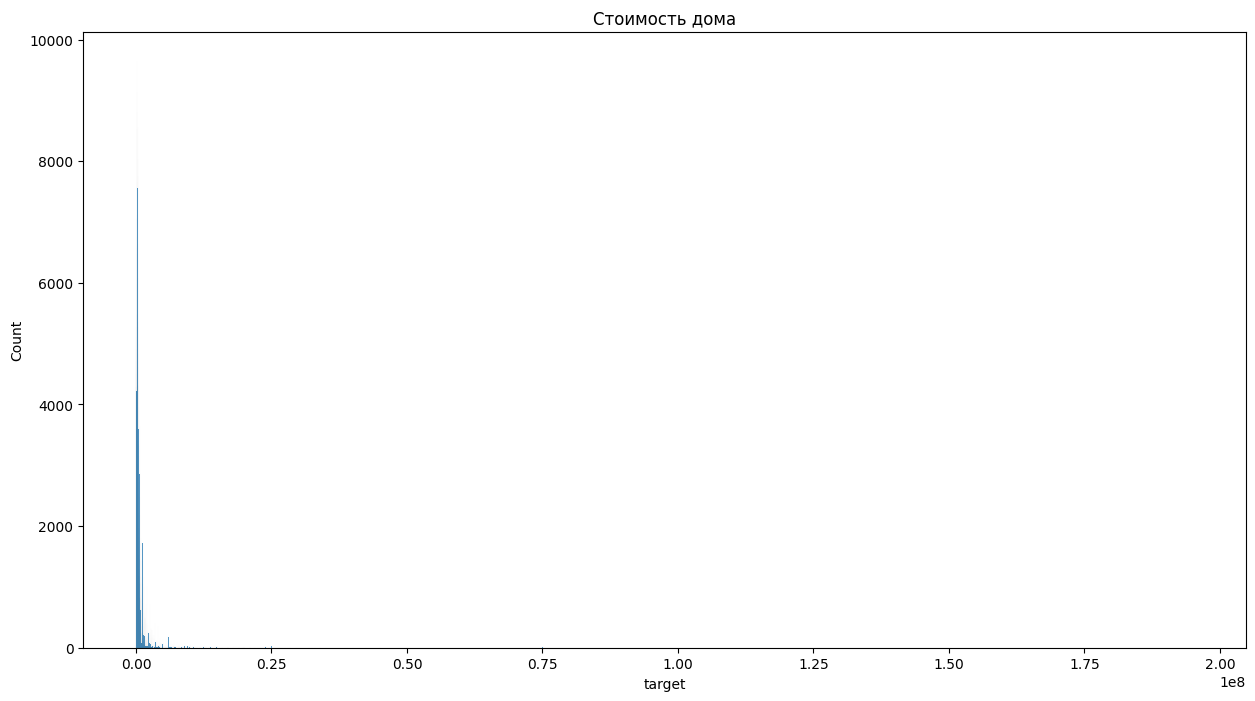

In [73]:
plt.figure(figsize=(15,8))
plt.title('Стоимость дома')
sns.histplot(df['target'])
plt.show()

In [74]:
mask = df['target'] < 10_000_000
df = df[mask]

Проверим корреляцию числовых признаков.

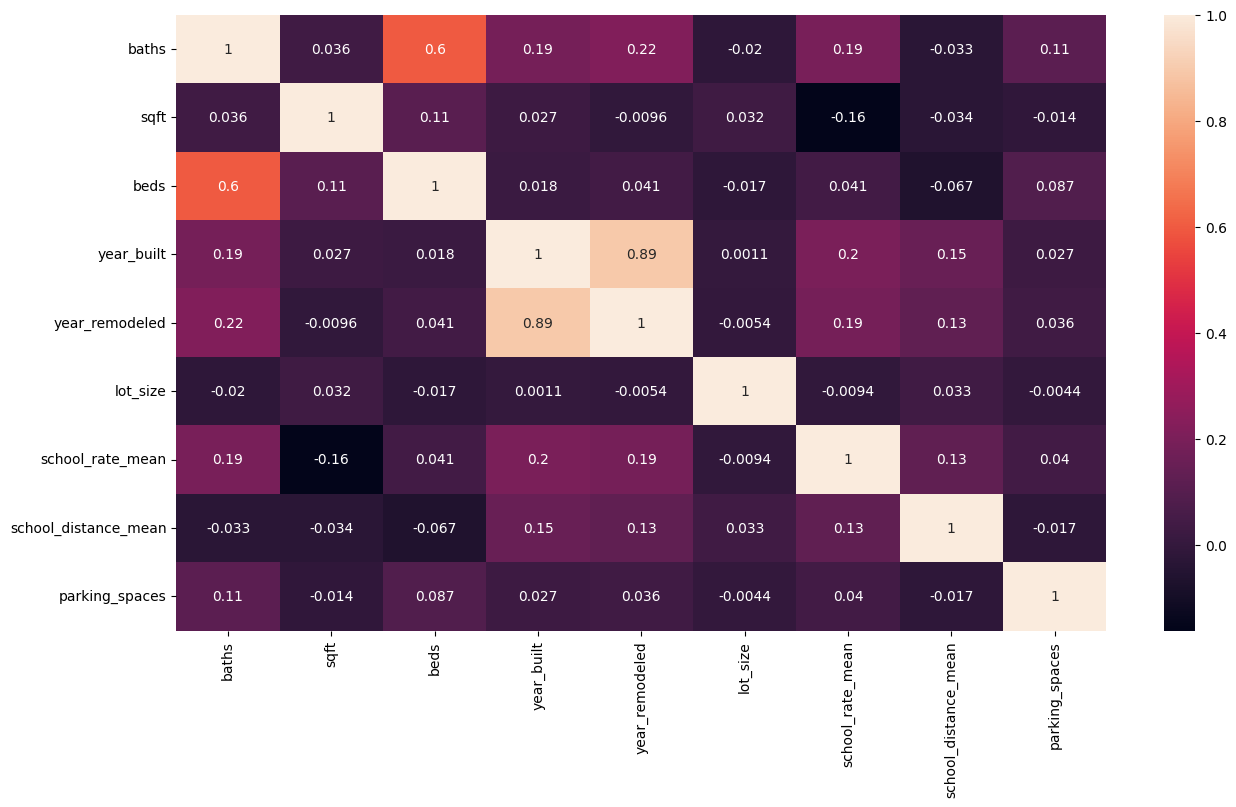

In [76]:
plt.figure(figsize=(15,8))
sns.heatmap(df[[
    'baths',
    'sqft',
    'beds',
    'year_built',
    'year_remodeled',
    'lot_size',
    'school_rate_mean',
    'school_distance_mean',
    'parking_spaces'
]].corr(), annot=True)
plt.show()

Удалим признак year_remodeled, который сильно коррелирует с признаком year_built.

In [77]:
df = df.drop('year_remodeled', axis=1)

Выделим признаки и целевую переменную, а также разделим датасет на обучающую и тестовую выборки.

In [82]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Масштабируем признаки.

In [83]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)

В качестве baseline будем использовать линейную регрессию,а в качестве метрики — RMSE.

In [84]:
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)
y_train_pred = linreg.predict(X_train_scaled)
y_test_pred  = linreg.predict(X_test_scaled)
print('Train RMSE:', mean_squared_error(y_train, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

Train RMSE: 719635.7903889805
Test RMSE: 714172.0277298869


Будем вести табличку результатов.

In [85]:
table_dict = dict()
table_columns = ['Train', 'Test']
table_dict['Linear regression'] = [
    mean_squared_error(y_train, y_train_pred, squared=False),
    mean_squared_error(y_test, y_test_pred, squared=False)
]

Добавим регуляризацию. Подберем коэффициент регуляризации с помощью GridSearchCV.

In [92]:
linrg = Ridge(random_state=42)

parameters = {
    'alpha' : [0.1, 0.5, 1, 2, 5, 10]
}
grid_lr = GridSearchCV(
    estimator = linrg,
    param_grid = parameters,
    scoring = 'neg_root_mean_squared_error',
    cv = 5,
    verbose=True,
    n_jobs=-1
)


grid_lr.fit(X_train_scaled, y_train)
lr_best_params = grid_lr.best_params_
print('Оптимальные параметры:', grid_lr.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Оптимальные параметры: {'alpha': 10}


In [93]:
linrg = Ridge(random_state=42, **lr_best_params)
linrg.fit(X_train_scaled, y_train)
y_train_pred = linrg.predict(X_train_scaled)
y_test_pred  = linrg.predict(X_test_scaled)
print('Train RMSE:', mean_squared_error(y_train, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

Train RMSE: 719635.7121489758
Test RMSE: 714170.9631135046


In [94]:
table_dict['Linear regression (r12n)'] = [
    mean_squared_error(y_train, y_train_pred, squared=False),
    mean_squared_error(y_test, y_test_pred, squared=False)
]

In [95]:
dectree = DecisionTreeRegressor(random_state=42, criterion='squared_error')

parameters = {
    'splitter' : ['best', 'random'],
    'max_depth' : [4, 5, 6],
    'min_samples_split' : [4, 6, 8]
}

grid_dt = GridSearchCV(
    estimator = dectree,
    param_grid = parameters,
    scoring = 'neg_root_mean_squared_error',
    cv = 5,
    verbose=True,
    n_jobs=-1
)


grid_dt.fit(X_train_scaled, y_train)
dt_best_params = grid_dt.best_params_
print('Оптимальные параметры:', grid_dt.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Оптимальные параметры: {'max_depth': 6, 'min_samples_split': 4, 'splitter': 'best'}


{'max_depth': 6, 'min_samples_split': 4, 'splitter': 'best'}

In [96]:
dectree = DecisionTreeRegressor(random_state=42, criterion='squared_error', **dt_best_params)
dectree.fit(X_train_scaled, y_train)
y_train_pred = dectree.predict(X_train_scaled)
y_test_pred  = dectree.predict(X_test_scaled)
print('Train RMSE:', mean_squared_error(y_train, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

Train RMSE: 664299.1056050058
Test RMSE: 661162.8953026426


In [97]:
table_dict['Decision Tree'] = [
    mean_squared_error(y_train, y_train_pred, squared=False),
    mean_squared_error(y_test, y_test_pred, squared=False)
]

In [98]:
randfor = RandomForestRegressor(random_state=42)

parameters = {
    'n_estimators' : [100, 150, 200],
    'criterion' : ['squared_error'],
    'max_depth': range(4, 8),
    'min_samples_split': [2, 4, 6]   
}

grid_rf = GridSearchCV(
    estimator=randfor,
    param_grid=parameters,
    scoring = 'neg_root_mean_squared_error',
    cv = 5,
    verbose=True,
)

grid_rf.fit(X_train_scaled, y_train)
rf_best_params = grid_rf.best_params_
print('Оптимальные параметры:', grid_rf.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Оптимальные параметры: {'criterion': 'squared_error', 'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 200}


{'criterion': 'squared_error', 'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 100}

In [99]:
randfor = RandomForestRegressor(random_state=42, **rf_best_params)
randfor.fit(X_train_scaled, y_train)
y_train_pred = randfor.predict(X_train_scaled)
y_test_pred  = randfor.predict(X_test_scaled)
print('Train RMSE:', mean_squared_error(y_train, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

Train RMSE: 631731.629515307
Test RMSE: 631999.2771518213


In [100]:
table_dict['Random Forest'] = [
    mean_squared_error(y_train, y_train_pred, squared=False),
    mean_squared_error(y_test, y_test_pred, squared=False)
]

In [101]:
xgb = XGBRegressor(seed=42)
xgb.fit(X_train_scaled, y_train)
y_train_pred = xgb.predict(X_train_scaled)
y_test_pred  = xgb.predict(X_test_scaled)
print('Train RMSE:', mean_squared_error(y_train, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

Train RMSE: 482002.0984805611
Test RMSE: 518616.85397251585


In [102]:
table_dict['XGBoost'] = [
    mean_squared_error(y_train, y_train_pred, squared=False),
    mean_squared_error(y_test, y_test_pred, squared=False)
]

Итоговая таблица.

In [104]:
final_table = pd.DataFrame.from_dict(data=table_dict, orient='index', columns=table_columns)
final_table.round(2)

,Train,Test
Linear regression,719635.79,714172.03
Linear regression (r12n),719635.71,714170.96
Decision Tree,664299.11,661162.90
Random Forest,631731.63,631999.28
XGBoost,482002.10,518616.85


Наилучший показатель у модели XGBoost, поэтому для решения задачи будем использовать ее.